In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.image as mpimg
import os.path
import os
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
#creating a directory
image_dir = Path('../input/food41/images')

In [3]:
class_names = sorted(os.listdir(image_dir))
n_classes = len(class_names)

In [4]:
# Discover names of all 101 food classes in the dataset
print(f"Total Number of Classes : {n_classes} \nClass Names : {class_names}")

Total Number of Classes : 101 
Class Names : ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich',

## Creating File DataFrame

In [5]:
#creating a Pandas dataframe
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

images = pd.concat([filepaths, labels], axis=1)

category_samples = []
for category in images['Label'].unique():
    category_slice = images.query("Label == @category")
    category_samples.append(category_slice.sample(100, random_state=1))
image_df = pd.concat(category_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [6]:
#checking how many photos are in each class - 100 as is expected
image_df['Label'].value_counts()

greek_salad         100
huevos_rancheros    100
french_toast        100
tacos               100
clam_chowder        100
                   ... 
escargots           100
chicken_wings       100
crab_cakes          100
fried_rice          100
macarons            100
Name: Label, Length: 101, dtype: int64

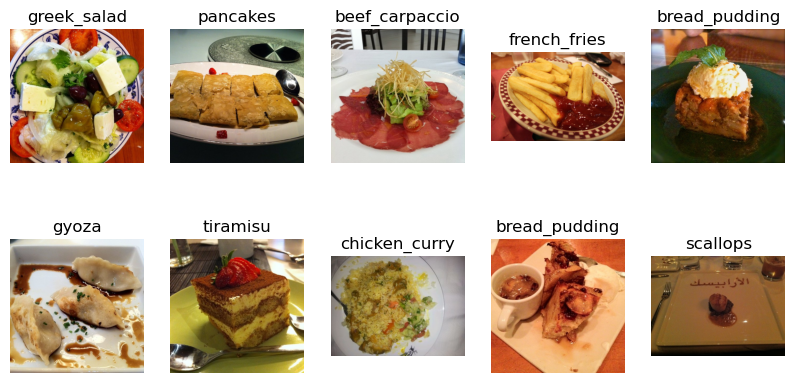

In [7]:
# display the first 10 images and their labels
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
axs = axs.flatten()

for i in range(10):
    img_name = image_df['Filepath'].iloc[i]
    img_label = image_df['Label'].iloc[i]
    
    img = cv2.imread(img_name)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    axs[i].imshow(img)
    axs[i].set_title(img_label)
    axs[i].axis('off')

plt.show()

## Train-Test Split

In [8]:
#creating two image data generators - first one for train and validation datasets and the second one for test dataset
train_df, test_df = train_test_split(image_df, train_size=0.7, shuffle=True, random_state=1)

In [9]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
     rescale=1./255,
)

In [10]:
# setup dataset

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 5656 validated image filenames belonging to 101 classes.
Found 1414 validated image filenames belonging to 101 classes.
Found 3030 validated image filenames belonging to 101 classes.


In [11]:
#defining a CNN using the VGG16 architecture pre-trained on the ImageNet dataset
pretrained = tf.keras.applications.VGG16(
    input_shape=[224, 224, 3], include_top=False, 
    weights='imagenet'
)

pretrained.trainable = False

model = tf.keras.models.Sequential([
    pretrained,
    tf.keras.layers.GlobalAveragePooling2D(),
    layers.Dropout(0.25),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.1),
    layers.Dense(n_classes, activation='softmax')
])

58889256/58889256 [==============================] - 3s 0us/step


In [12]:

#let's configure the learning process using Adam optimizer and
#look at the architecture of the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[ 'AUC']
)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0

In [13]:
#training the model with a batch size of 64 and saving the training history for further analysis
EPOCHS = 50
BATCH_SIZE = 64
early_stop = EarlyStopping(monitor='val_loss',min_delta=0.00000001, patience=5000, restore_best_weights = True)
history2 = model.fit(train_images,
                    steps_per_epoch=train_images.samples // BATCH_SIZE // 2,
                    epochs=EPOCHS,
                    validation_data=val_images,
                    validation_steps= val_images.samples // BATCH_SIZE // 2,
                    verbose=1,
                    callbacks=[early_stop],
                    shuffle=True)

Epoch 1/50
44/44 [==============================] - 39s 582ms/step - loss: 5.0894 - auc: 0.5109 - val_loss: 4.6157 - val_auc: 0.5421
Epoch 2/50
44/44 [==============================] - 22s 511ms/step - loss: 4.7168 - auc: 0.5796 - val_loss: 4.5054 - val_auc: 0.6124
Epoch 3/50
44/44 [==============================] - 23s 520ms/step - loss: 4.5851 - auc: 0.6216 - val_loss: 4.4605 - val_auc: 0.6384
Epoch 4/50
44/44 [==============================] - 19s 442ms/step - loss: 4.4524 - auc: 0.6596 - val_loss: 4.3666 - val_auc: 0.6827
Epoch 5/50
44/44 [==============================] - 17s 395ms/step - loss: 4.3307 - auc: 0.6905 - val_loss: 4.3067 - val_auc: 0.7073
Epoch 6/50
44/44 [==============================] - 18s 416ms/step - loss: 4.2039 - auc: 0.7245 - val_loss: 4.2408 - val_auc: 0.7198
Epoch 7/50
44/44 [==============================] - 15s 335ms/step - loss: 4.1918 - auc: 0.7313 - val_loss: 4.1875 - val_auc: 0.7371
Epoch 8/50
44/44 [==============================] - 17s 381ms/step - 

In [14]:
#assessing the model's performance on the test dataset
loss, auc = model.evaluate(test_images)

95/95 [==============================] - 49s 518ms/step - loss: 3.1907 - auc: 0.8613


In [15]:
#checking the available metrics
history_dict2 = history2.history

print(history_dict2.keys())

dict_keys(['loss', 'auc', 'val_loss', 'val_auc'])


In [16]:
def plot_train_instrumentation(epochs, data, train_param, val_param):
    
    plt.figure(figsize=(10,7))
    
    plt.plot(epochs, data[train_param], 'g', label=f'Training ({train_param})')
    plt.plot(epochs, data[val_param], 'red', label=f'Validation ({val_param})')
    
    plt.title("Training performance")
    plt.xlabel('Epochs')
    plt.ylabel(train_param)
    
    plt.legend()
    plt.show()

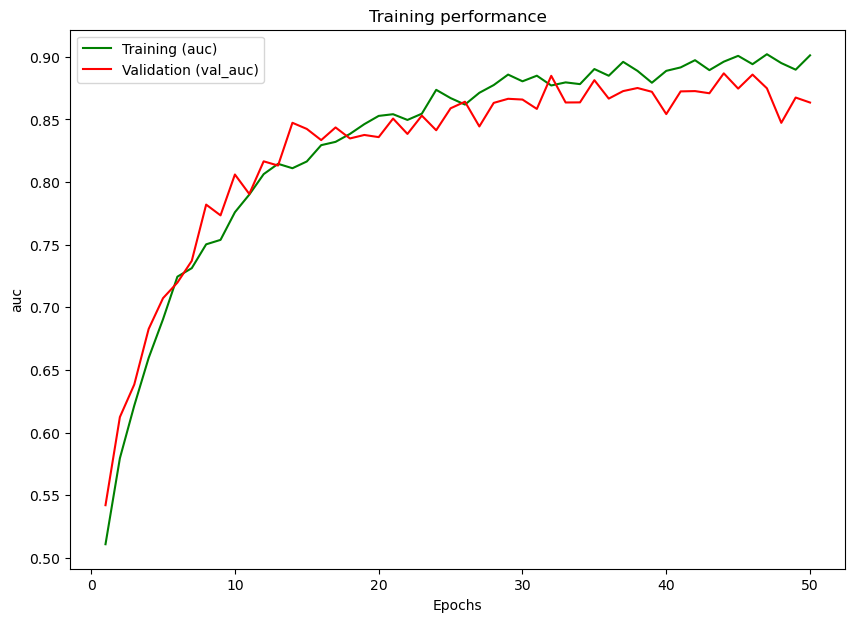

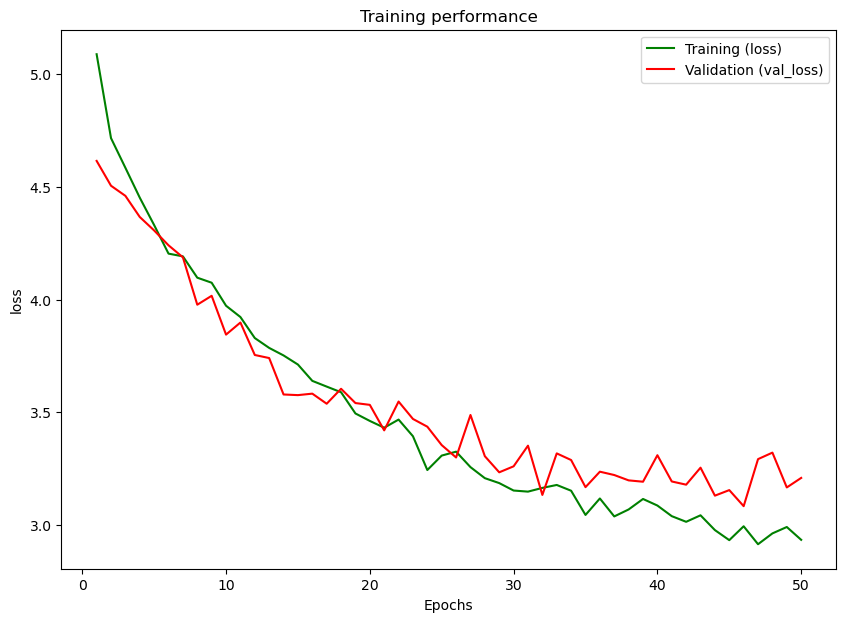

In [17]:
#using the previously defined function to see the model's performance
#the loss functions don't converge in one point at the end 
#there is a need to apply data augmentation or tune hypermarameters, but so far this is the best version we've been able to get
epochs = range(1, len(history_dict2['auc'])+1)

plot_train_instrumentation(epochs, history_dict2, 'auc', 'val_auc')
plot_train_instrumentation(epochs, history_dict2, 'loss', 'val_loss')

In [18]:
#let's generate a classification report for the predictions made by the trained model on the test dataset 
#to summarise the model's performance on each class
predictions = np.argmax(model.predict(test_images), axis=1)


report = classification_report(test_images.labels, predictions, target_names=test_images.class_indices, zero_division=0)

95/95 [==============================] - 22s 231ms/step


In [19]:

#let's look at the report
#the metrics vary between classes: the lowest F1 score is 0 for steak class and the highest is 0.97 for edamame class
print(report)

                         precision    recall  f1-score   support

              apple_pie       0.10      0.09      0.09        34
         baby_back_ribs       0.12      0.09      0.10        23
                baklava       0.00      0.00      0.00        30
         beef_carpaccio       0.17      0.13      0.15        30
           beef_tartare       0.20      0.06      0.09        33
             beet_salad       0.19      0.44      0.26        27
               beignets       0.16      0.58      0.25        24
               bibimbap       0.23      0.25      0.24        28
          bread_pudding       0.04      0.04      0.04        25
      breakfast_burrito       0.12      0.04      0.06        25
             bruschetta       0.00      0.00      0.00        33
           caesar_salad       0.57      0.18      0.28        44
                cannoli       0.09      0.15      0.11        26
          caprese_salad       0.11      0.11      0.11        27
            carrot_cake 